
Количество, т
2022-12-31    22015.648445
2023-12-31    24713.940399
2024-12-31    22291.330466
Freq: YE-DEC, Name: predicted_mean, dtype: float64
p-значение: 1.6160109187766174e-11


Стоимость, тыс.долл. США
2022-12-31    5965.591231
2023-12-31    6882.460028
2024-12-31    6009.603894
Freq: YE-DEC, Name: predicted_mean, dtype: float64
p-значение: 0.0



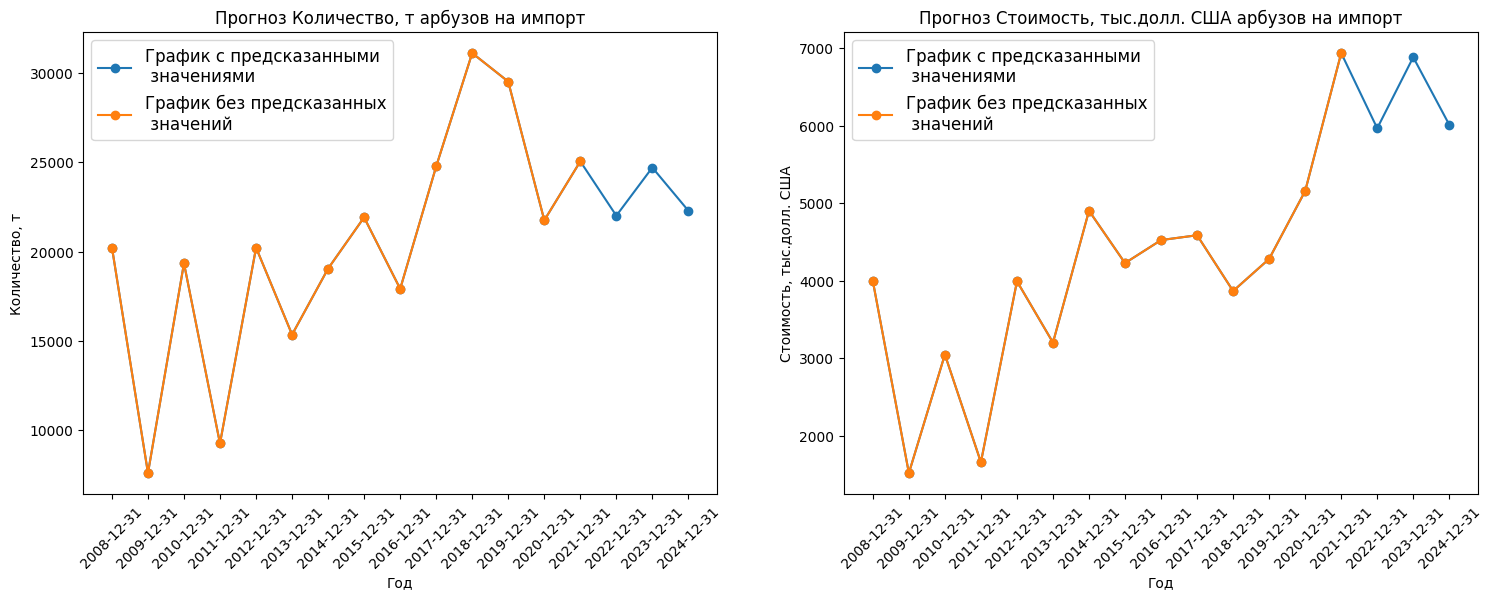


Количество, т
2022-12-31    24.637398
2023-12-31    34.410923
2024-12-31    41.426110
Freq: YE-DEC, Name: predicted_mean, dtype: float64
p-значение: 0.00022476222903944414


Стоимость, тыс.долл. США
2022-12-31    6.323421
2023-12-31    7.202453
2024-12-31    7.927843
Freq: YE-DEC, Name: predicted_mean, dtype: float64
p-значение: 1.1655469398598854e-05



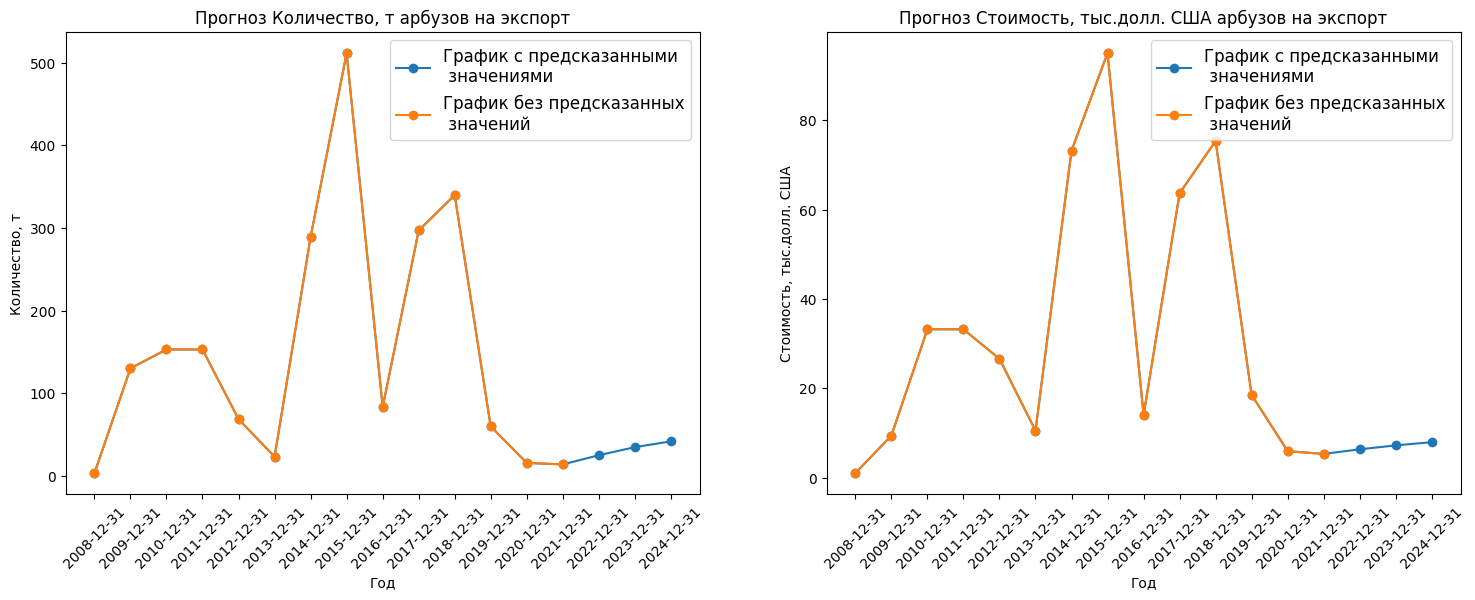

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
export_df = pd.read_excel('export.xlsx')
import_df = pd.read_excel('import.xlsx')

def fill_nan(df, column, method):
    df.fillna({column : method}, inplace=True)

dfs = [import_df, export_df]
for df in dfs:
    for column in df.columns[1:]:
        fill_nan(df, column, df[column].mean())

for df in dfs:
    df.reset_index(drop=True, inplace=True)
    df['Год'] = pd.to_datetime(df['Год'], format='%Y') 
    df.set_index('Год', inplace=True)
    df.index = pd.date_range(start='2008-01-01', periods=len(df), freq='YE')

future_years = pd.date_range(start='2022-01-01', periods=3, freq='YE')

new_rows = {'Год': future_years, 'Количество, т': None,	'Стоимость, тыс.долл. США': None}
new_rows = pd.DataFrame(new_rows, index=pd.to_datetime(new_rows['Год'], format='%Y'))
new_rows.drop(columns=['Год'], inplace=True)

for df, export_or_import in zip(dfs, ["импорт", 'экспорт']):
    for column, measure in zip(df.columns, ['тонн', 'тыс. долларов']):
        print()
        df['Log'] = np.log(df[column])
        df['Diff_Log'] = df['Log'].diff().dropna()
        df['2_Diff_Log'] = df['Diff_Log'].diff().dropna()
        result = adfuller(df['2_Diff_Log'].dropna())
        model = ARIMA(df['Log'].dropna(), order=(1, 1, 1))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=3)
        print(column, np.exp(forecast), sep='\n')
        print('p-значение:', result[1], end='\n\n')
        
        
        new_rows[column] = np.array(np.exp(forecast))

    df_with_predicted_values = df.copy()
    df_with_predicted_values = pd.concat([df_with_predicted_values, new_rows]) 
    
    fig, axes = plt.subplots(1,2, figsize=(18,6))
    
    for idx, column in enumerate(df.columns[:2]):
       
        axes[idx].plot(df_with_predicted_values.index, df_with_predicted_values.loc[:, column], marker='o', label='График с предсказанными\n значениями')
        axes[idx].plot(df.index, df.loc[:, column], marker='o', label='График без предсказанных\n значений')
        axes[idx].set_xlabel('Год')
        axes[idx].set_ylabel(column)
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].set_xticks(df_with_predicted_values.index)
        axes[idx].set_title(f'Прогноз {column} арбузов на {export_or_import}')
        if export_or_import == 'экспорт':
            axes[idx].legend(loc='upper right', fontsize=12)
        else:
            axes[idx].legend(loc='upper left', fontsize=12)
    plt.show()


